# Import Libraries 

In [7]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import random
import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 , ResNet50,MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Check duplicate images Using Imagehash library

In [8]:
import shutil
import imagehash
from PIL import Image
from tqdm import tqdm  # Progress bar

#Define the path
dataset_folder = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"
output_folder = "/kaggle/working/cleaned_dataset"

# Create output folder
os.makedirs(output_folder, exist_ok=True)

# Function to remove duplicates and save unique images
def remove_duplicates_and_save(image_folder, output_label_folder):
    hashes = {}  # Store image hashes
    os.makedirs(output_label_folder, exist_ok=True)  # Create label folder

    all_images = os.listdir(image_folder)  # Get all images in folder
    total_images = len(all_images)  # Count total images
    duplicate_count = 0  # Counter for duplicate images

    for img_name in tqdm(all_images, desc=f"Processing {os.path.basename(image_folder)}"):
        img_path = os.path.join(image_folder, img_name)
        output_img_path = os.path.join(output_label_folder, img_name)

        try:
            img = Image.open(img_path).convert("RGB")  # Ensure correct format
            img_hash = imagehash.phash(img)  # Compute perceptual hash

            if img_hash not in hashes:  # If unique image
                hashes[img_hash] = img_path
                shutil.copy(img_path, output_img_path)  # Copy unique image
            else:
                duplicate_count += 1  # Increment duplicate counter

        except Exception as e:
            print(f" Error processing {img_name}: {e}")

    unique_images = total_images - duplicate_count  # Calculate remaining images

    # Print stats for the folder
    print(f"\n Label: {os.path.basename(image_folder)}")
    print(f" Total images: {total_images}")
    print(f" Duplicates removed: {duplicate_count}")
    print(f"Unique images saved: {unique_images}\n")

# Process each label folder separately
for label in os.listdir(dataset_folder):
    label_path = os.path.join(dataset_folder, label)
    output_label_path = os.path.join(output_folder, label)

    if os.path.isdir(label_path):  # Ensure it's a folder
        remove_duplicates_and_save(label_path, output_label_path)

print("\n✅ Dataset cleaned and saved in:", output_folder)


Processing Cyst: 100%|██████████| 3709/3709 [01:00<00:00, 61.42it/s]



 Label: Cyst
 Total images: 3709
 Duplicates removed: 2063
Unique images saved: 1646



Processing Tumor: 100%|██████████| 2283/2283 [00:38<00:00, 59.62it/s]



 Label: Tumor
 Total images: 2283
 Duplicates removed: 1172
Unique images saved: 1111



Processing Stone: 100%|██████████| 1377/1377 [00:23<00:00, 58.87it/s]



 Label: Stone
 Total images: 1377
 Duplicates removed: 678
Unique images saved: 699



Processing Normal: 100%|██████████| 5077/5077 [01:21<00:00, 62.20it/s]


 Label: Normal
 Total images: 5077
 Duplicates removed: 2537
Unique images saved: 2540


✅ Dataset cleaned and saved in: /kaggle/working/cleaned_dataset


In [9]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


# Splite The data to Train ,Test and Validation

In [10]:
import splitfolders 

# Define the cleaned dataset path
cleaned_dataset_folder = "/kaggle/working/cleaned_dataset"
output_split_folder = "/kaggle/working/split_dataset"

# Split the dataset into train, val, and test (70% - 15% - 15%)
splitfolders.ratio(cleaned_dataset_folder, output=output_split_folder, seed=42, ratio=(0.7, 0.15, 0.15))

print("\n✅ Dataset successfully split into Training, Validation, and Test sets!")


Copying files: 5996 files [00:01, 4250.62 files/s]


✅ Dataset successfully split into Training, Validation, and Test sets!


In [11]:
data_dirs = {
    "Train": "/kaggle/working/split_dataset/train",  
}

# Calculate the number of images in each class within each part
for data_type, path in data_dirs.items():
    print(f"\n {data_type} Data:")
    for class_name in os.listdir(path):  
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):  
            num_images = len(os.listdir(class_path))  
            print(f"  {class_name}: {num_images} images")



 Train Data:
  Cyst: 1152 images
  Stone: 489 images
  Normal: 1778 images
  Tumor: 777 images


**Imbalanced Data**

#  Data Augmentation for Tumor and Stone Class

In [12]:
train_dir = "/kaggle/working/split_dataset/train"

# Augmentation للصور
augmenter = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.1,
    height_shift_range=0.1,  
    shear_range=0.1, 
    zoom_range=0.1,  
    brightness_range=[0.9, 1.1],  
    fill_mode='nearest'
)

# Determine the classes that we will provide
classes_to_augment = ["Stone", "Tumor"]
target_images_per_class = 1200  # The target number after the Augmentation

for class_name in classes_to_augment:
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)
    
    num_existing_images = len(images)
    num_needed = target_images_per_class - num_existing_images
    
    print(f" {class_name}: has {num_existing_images} Image, we need {num_needed} Additional image")

    i = 0
    while num_existing_images + i < target_images_per_class:
        img_path = os.path.join(class_path, images[i % num_existing_images])  
        image = Image.open(img_path)
        image = np.array(image)
        image = image.reshape((1,) + image.shape)  #Transforming the image to a form that fits the Augmentation
        
        save_prefix = f"{class_name}_aug_{i}"  
        for batch in augmenter.flow(image, batch_size=1, save_to_dir=class_path, save_prefix=save_prefix, save_format="png"):
            i += 1
            if num_existing_images + i >= target_images_per_class:
                break
    
    print(f" The new photos were added to {class_name}, The number of Images has become: {target_images_per_class}")



 Stone: has 489 Image, we need 711 Additional image
 The new photos were added to Stone, The number of Images has become: 1200
 Tumor: has 777 Image, we need 423 Additional image
 The new photos were added to Tumor, The number of Images has become: 1200


### Images after Augmentation 

In [13]:
data_dirs = {
    "Train": "/kaggle/working/split_dataset/train",  
}

# Calculate the number of images in each class within each part After Augmentation

print("Data After Augmentation")
for data_type, path in data_dirs.items():
    print(f"\n {data_type} Data:")
    for class_name in os.listdir(path):  
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):  
            num_images = len(os.listdir(class_path))  
            print(f"  {class_name}: {num_images} images")


Data After Augmentation

 Train Data:
  Cyst: 1152 images
  Stone: 1164 images
  Normal: 1778 images
  Tumor: 1190 images


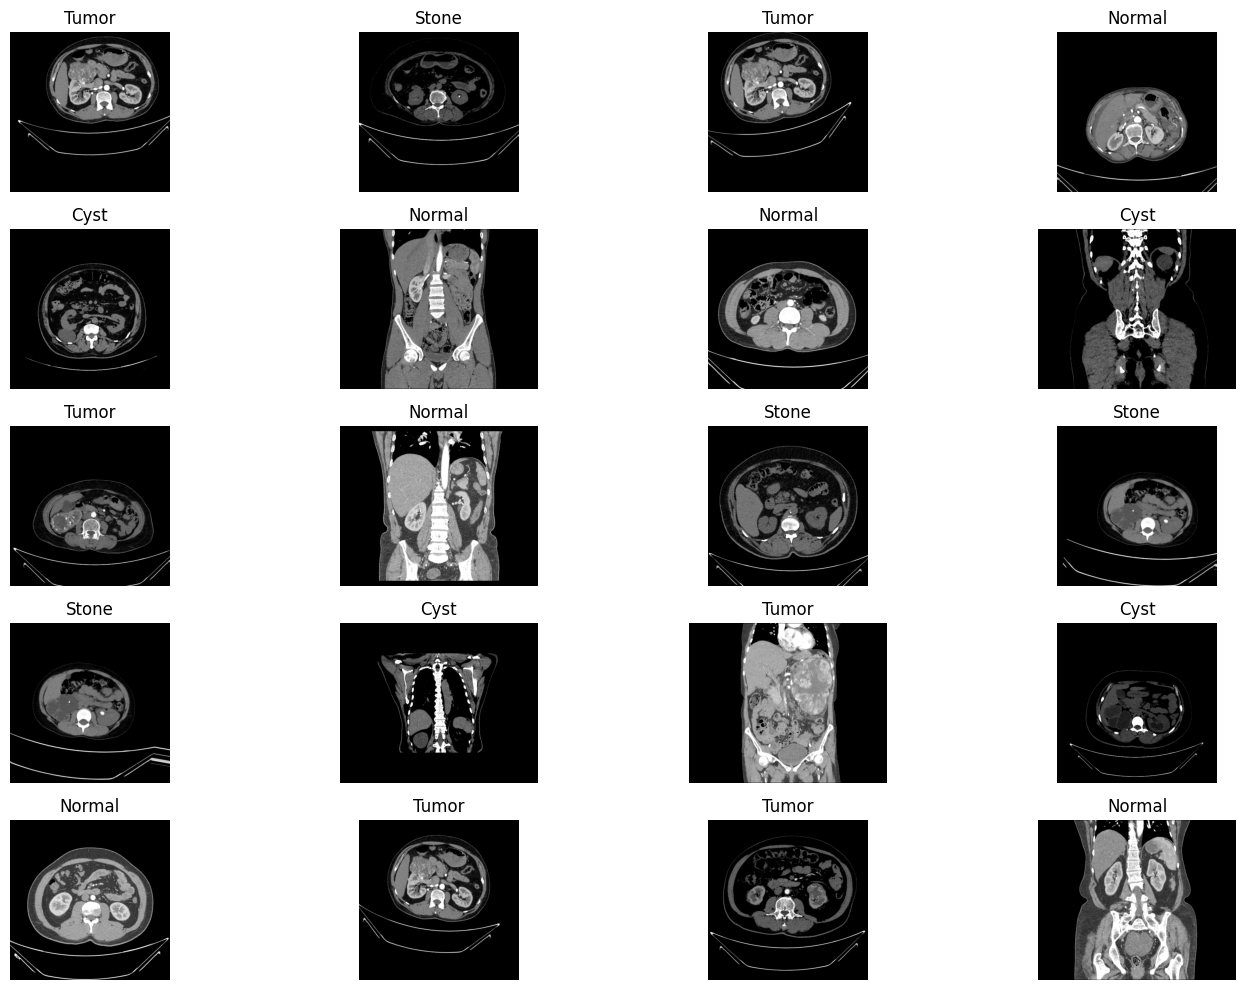

In [14]:
def display_images(data_path,num_img):
    random=np.random.randint(0,4,num_img)
    plt.figure(figsize=(15,10))
    for i in range(len(random)):
        # Get the list of class directories  
        class_name = os.listdir(data_path)[random[i]]
        class_path = os.path.join(data_path,class_name)
        random_img = np.random.randint(0,1000)
        image = os.listdir(class_path)[random_img]
        image_path = os.path.join(class_path,image)
        
        # Load and display the image  
        image = Image.open(image_path)
    
        plt.subplot(5,4,i+1)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

train_dir = "/kaggle/working/split_dataset/train"
display_images(train_dir , 20)

# Building The model

## Load and Prepare Images

In [15]:
train_dir = '/kaggle/working/split_dataset/train'
validation_dir = '/kaggle/working/split_dataset/val'
test_dir = '/kaggle/working/split_dataset/test'

train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    )

val_generator= validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5284 images belonging to 4 classes.
Found 897 images belonging to 4 classes.
Found 903 images belonging to 4 classes.


## 1- ResNet50

In [16]:
resnet_base = ResNet50(weights='imagenet',include_top=False , input_shape=(256,256,3))

model_resnet=Sequential()
model_resnet.add(resnet_base)
model_resnet.add(Flatten())
model_resnet.add(Dense(256, activation='relu'))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(4, activation='softmax'))

resnet_base.trainable=False

model_resnet.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

model_resnet.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,143,428 (217.98 MB)

 Trainable params: 33,555,716 (128.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
model_resnet.fit(train_generator,epochs=10,validation_data=val_generator,verbose=1,callbacks=[EarlyStopping(patience=5)])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


166/166 ━━━━━━━━━━━━━━━━━━━━ 52s 217ms/step - accuracy: 0.3731 - loss: 6.1584 - val_accuracy: 0.4281 - val_loss: 1.1913
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.4260 - loss: 1.1939 - val_accuracy: 0.4259 - val_loss: 1.3294
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.4341 - loss: 1.1971 - val_accuracy: 0.4247 - val_loss: 1.3000
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.4536 - loss: 1.0914 - val_accuracy: 0.4515 - val_loss: 0.9984
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.4517 - loss: 1.0599 - val_accuracy: 0.4872 - val_loss: 1.0402
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.4788 - loss: 1.0418 - val_accuracy: 0.5463 - val_loss: 0.9156
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.4801 - loss: 1.0416 - val_accuracy: 0.6678 - val_loss: 0.8393
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.5063 - loss: 1.0151 - val

In [18]:
test_loss, test_accuracy = model_resnet.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.1782 - loss: 1.2216
Test Accuracy: 25.33%


### Evaluate Resnet50

In [19]:
# Assuming you are using a test generator
y_pred_probs = model_resnet.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes


29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

              precision    recall  f1-score   support

        Cyst       0.50      0.24      0.32       248
      Normal       0.00      0.00      0.00       381
       Stone       0.33      0.21      0.25       106
       Tumor       0.21      0.91      0.35       168

    accuracy                           0.26       903
   macro avg       0.26      0.34      0.23       903
weighted avg       0.21      0.26      0.18       903

Confusion Matrix:
[[ 59   0  31 158]
 [ 23   0   2 356]
 [ 34   0  22  50]
 [  3   0  12 153]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


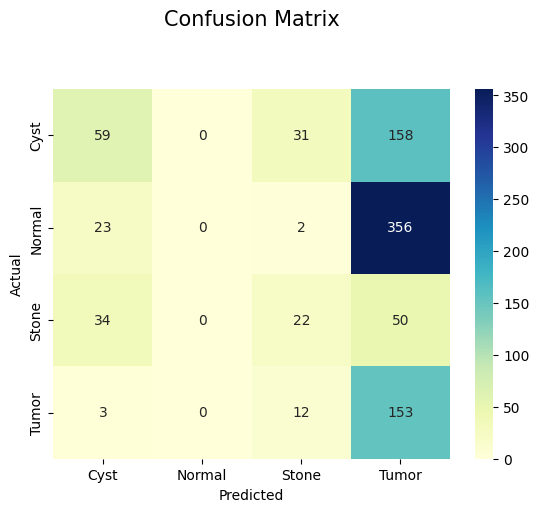

In [21]:
class_names = ["Cyst", "Normal","Stone" , "Tumor"]
# Drawing the confusion matrix with the names of the categories
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='g', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', y=1.15, size=15)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# Sensitivity (Recall) and Specificity Calculation
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)

print("____________________________________________")

print("Specificity:", specificity)

# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score: ", auc_score)
print("____________________________________________")
# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class:  ", dice_scores)
print("____________________________________________")
# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC):  ", average_dsc)

Sensitivity (Recall): [0.23790323 0.         0.20754717 0.91071429]
____________________________________________
Specificity: [0.90839695 1.         0.94353827 0.23265306]
AUC Score:  0.6369954377264634
____________________________________________
Dice Similarity Coefficient (DSC) for each class:   [0.32152589 0.         0.25433526 0.34576271]
____________________________________________
Average Dice Similarity Coefficient (DSC):   0.2304059643846492


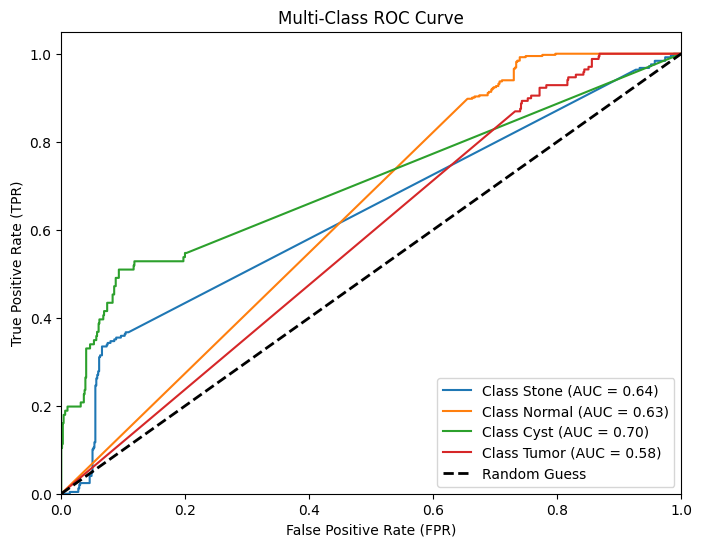

In [23]:
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = len(test_generator.class_indices)

# Convert true labels to one-hot encoding
y_true_one_hot = np.eye(num_classes)[y_true]

# Initialize the plot
plt.figure(figsize=(8, 6))


class_labels = ["Stone", "Normal", "Cyst", "Tumor"]
# Loop through each class to calculate and plot ROC curve
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()


## VGG_16

In [24]:
# Load VGG16 without the upper layers (fully connected layers)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

#Build the Model
model_vgg = Sequential()
model_vgg.add(vgg_base)
model_vgg.add(Flatten())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dropout(0.5))
model_vgg.add(Dense(4, activation='softmax'))

# Freeze the base model layers to prevent them from being trained
vgg_base.trainable = False

model_vgg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,104,580 (88.14 MB)

 Trainable params: 8,389,892 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
model_vgg.fit(train_generator,epochs=10,validation_data=val_generator,verbose=1,callbacks=[EarlyStopping(patience=5)])

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 72s 281ms/step - accuracy: 0.6048 - loss: 2.0136 - val_accuracy: 0.9142 - val_loss: 0.2816
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 36s 208ms/step - accuracy: 0.8908 - loss: 0.3202 - val_accuracy: 0.9744 - val_loss: 0.0945
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 203ms/step - accuracy: 0.9287 - loss: 0.1862 - val_accuracy: 0.9833 - val_loss: 0.0867
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - accuracy: 0.9325 - loss: 0.1822 - val_accuracy: 0.9844 - val_loss: 0.0405
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 206ms/step - accuracy: 0.9397 - loss: 0.1673 - val_accuracy: 0.9877 - val_loss: 0.0326
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.9409 - loss: 0.1470 - val_accuracy: 0.9766 - val_loss: 0.0733
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 204ms/step - accuracy: 0.9517 - loss: 0.1224 - val_accuracy: 0.9855 - val_loss: 0.0380
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - accuracy: 0.9510 - loss: 0

In [26]:
test_loss, test_accuracy = model_vgg.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9989 - loss: 0.0117
Test Accuracy: 99.67%


### Evaluate VGG 16

In [27]:
y_pred_probs = model_vgg.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes


29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 518ms/step


              precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00       248
      Normal       1.00      1.00      1.00       381
       Stone       0.99      0.98      0.99       106
       Tumor       1.00      0.99      1.00       168

    accuracy                           1.00       903
   macro avg       1.00      0.99      0.99       903
weighted avg       1.00      1.00      1.00       903



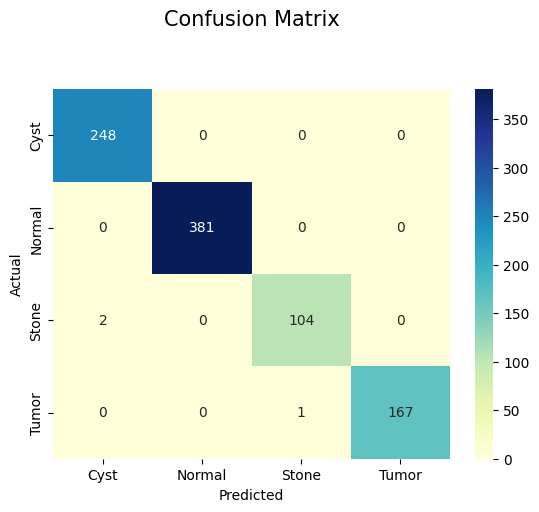

In [28]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = ["Cyst", "Normal", "Stone", "Tumor"]
# Drawing the confusion matrix with the names of the categories
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='g', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', y=1.15, size=15)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

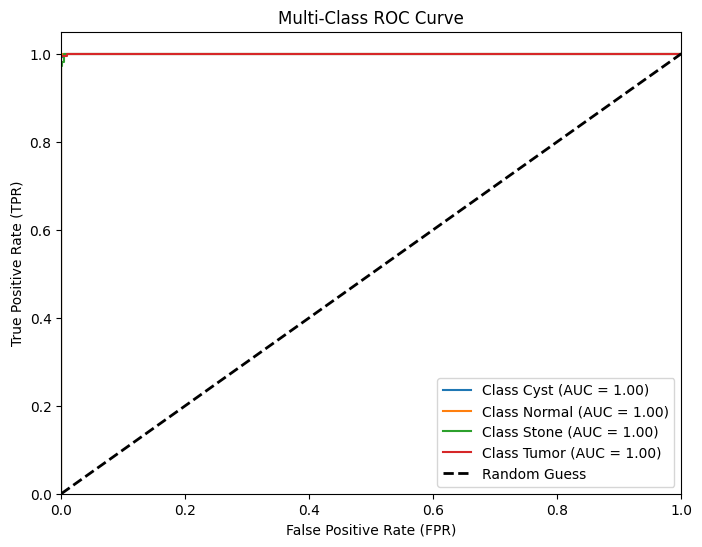

In [29]:
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = len(test_generator.class_indices)

# Convert true labels to one-hot encoding
y_true_one_hot = np.eye(num_classes)[y_true]

# Initialize the plot
plt.figure(figsize=(8, 6))


class_labels = ["Cyst", "Normal", "Stone", "Tumor"]
# Loop through each class to calculate and plot ROC curve
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [30]:
# Sensitivity (Recall) and Specificity Calculation
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall):", sensitivity)

print("____________________________________________")

print("Specificity:", specificity)

# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score: ", auc_score)
print("____________________________________________")
# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class:  ", dice_scores)
print("____________________________________________")
# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC):  ", average_dsc)

Sensitivity (Recall): [1.         1.         0.98113208 0.99404762]
____________________________________________
Specificity: [0.99694656 1.         0.99874529 1.        ]
AUC Score:  0.9999530386530029
____________________________________________
Dice Similarity Coefficient (DSC) for each class:   [0.99598394 1.         0.98578199 0.99701493]
____________________________________________
Average Dice Similarity Coefficient (DSC):   0.9946952129093583


## MobileNetv2

In [31]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)

model_mobNet = Model(inputs=base_model.input, outputs=output_layer)

model_mobNet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_mobNet.summary()

<ipython-input-31-0619c6acde49>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [32]:
model_mobNet.fit(train_generator,epochs=10,validation_data=val_generator,verbose=1,callbacks=[EarlyStopping(patience=2)])

Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 46s 206ms/step - accuracy: 0.4749 - loss: 1.2304 - val_accuracy: 0.7414 - val_loss: 0.7939
Epoch 2/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 150ms/step - accuracy: 0.7424 - loss: 0.7184 - val_accuracy: 0.8105 - val_loss: 0.6224
Epoch 3/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 26s 149ms/step - accuracy: 0.8009 - loss: 0.5749 - val_accuracy: 0.8428 - val_loss: 0.5146
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.8362 - loss: 0.4755 - val_accuracy: 0.8796 - val_loss: 0.4398
Epoch 5/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.8656 - loss: 0.3990 - val_accuracy: 0.8986 - val_loss: 0.3818
Epoch 6/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.8915 - loss: 0.3377 - val_accuracy: 0.9153 - val_loss: 0.3381
Epoch 7/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.9036 - loss: 0.3025 - val_accuracy: 0.9197 - val_loss: 0.2936
Epoch 8/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9117 - loss: 0

In [33]:
test_loss, test_accuracy = model_mobNet.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9647 - loss: 0.1818
Test Accuracy: 94.75%


### Evaluate MobileNet

In [34]:
y_pred_probs = model_mobNet.predict(test_generator)  # Get predicted probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# True labels
y_true = test_generator.classes

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step


              precision    recall  f1-score   support

        Cyst       0.92      0.96      0.94       248
      Normal       0.94      0.99      0.97       381
       Stone       0.94      0.82      0.87       106
       Tumor       0.97      0.87      0.92       168

    accuracy                           0.94       903
   macro avg       0.94      0.91      0.93       903
weighted avg       0.94      0.94      0.94       903



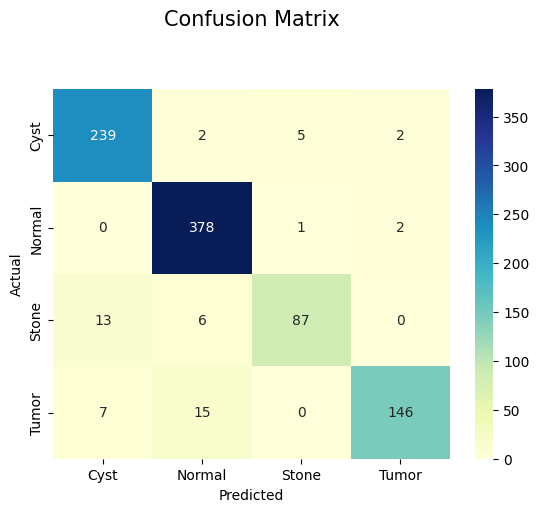

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Generate the classification report (includes precision, recall, F1-score)
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = ["Cyst", "Normal", "Stone", "Tumor"]
# Drawing the confusion matrix with the names of the categories
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='g', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', y=1.15, size=15)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
TP = np.diag(cm)  # True Positives
FP = cm.sum(axis=0) - TP  # False Positives
FN = cm.sum(axis=1) - TP  # False Negatives
TN = cm.sum() - (FP + FN + TP)  # True Negatives

sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

print("Sensitivity (Recall): ", sensitivity)
print("_________________________________________________")

print("Specificity: ", specificity)
print("_________________________________________________")
# Compute AUC (one-vs-rest for multi-class)
y_true_one_hot = np.eye(len(test_generator.class_indices))[y_true]  # Convert to one-hot encoding
auc_score = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
print("AUC Score:", auc_score)
print("_________________________________________________")

# Compute DSC (Dice Similarity Coefficient) for each class
dice_scores = (2 * TP) / (2 * TP + FP + FN)
print("Dice Similarity Coefficient (DSC) for each class: ", dice_scores)
print("_________________________________________________")
# Average Dice Score
average_dsc = np.mean(dice_scores)
print("Average Dice Similarity Coefficient (DSC): ", average_dsc)

Sensitivity (Recall):  [0.96370968 0.99212598 0.82075472 0.86904762]
_________________________________________________
Specificity:  [0.96946565 0.9559387  0.99247177 0.99455782]
_________________________________________________
AUC Score: 0.9935477220177531
_________________________________________________
Dice Similarity Coefficient (DSC) for each class:  [0.94280079 0.96675192 0.87437186 0.91823899]
_________________________________________________
Average Dice Similarity Coefficient (DSC):  0.9255408900300943


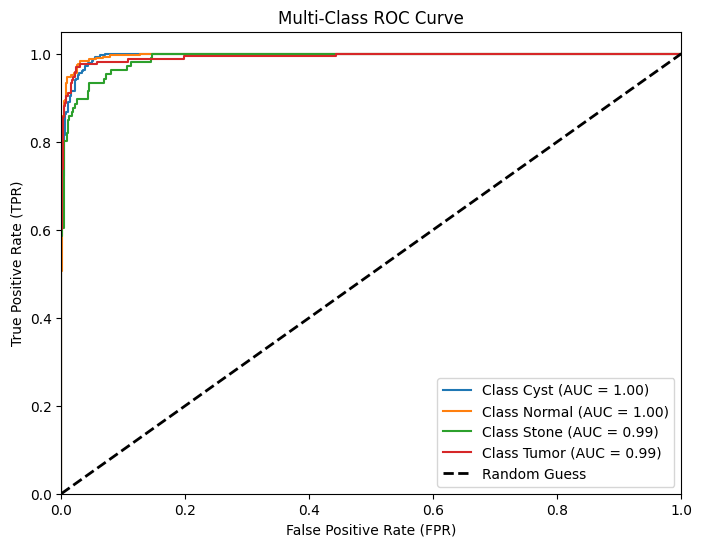

In [37]:
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = len(test_generator.class_indices)

# Convert true labels to one-hot encoding
y_true_one_hot = np.eye(num_classes)[y_true]

# Initialize the plot
plt.figure(figsize=(8, 6))


class_labels = ["Cyst", "Normal", "Stone", "Tumor"]
# Loop through each class to calculate and plot ROC curve
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random Guess")

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [38]:
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from io import BytesIO

# Function to download and preprocess the image
def load_image_from_url(url, target_size=(256, 256)):  # Adjust size as per your model input
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))

    # Convert to RGB (in case the image is grayscale)
    image = image.convert("RGB")

    # Resize to match the model's expected input
    image = image.resize(target_size)

    # Convert to numpy array and normalize
    image_array = np.array(image) / 255.0  # Normalize (Rescale)

    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)

    return image_array, image

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


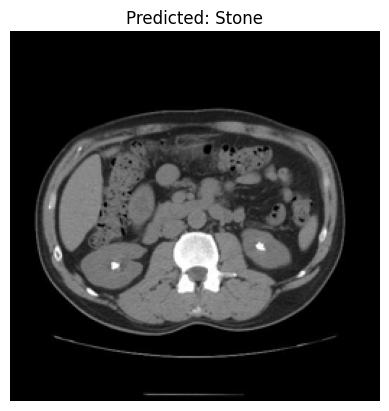

In [39]:
image_url = "https://prod-images-static.radiopaedia.org/images/24804/1af425ddaf16fa001b5d129ec2ecbb_big_gallery.jpeg"

# Load and preprocess the image
image_array, image = load_image_from_url(image_url)

# Make a prediction
predictions = model_mobNet.predict(image_array)
predicted_class = np.argmax(predictions)  # Get the predicted class index

# Class labels (update according to your dataset)
class_labels = ["Cyst","Normal","Stone", "Tumor"]
predicted_label = class_labels[predicted_class]

# Display the image with the prediction
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {predicted_label}")
plt.show()

In [40]:
model_mobNet.save('/kaggle/working/mobileNet_model.keras')